In [1]:
import torch
from datetime import datetime
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


torch.manual_seed(42) # To ensure sanity

In [2]:
cwd = Path.cwd()
cut_folder = cwd / "Field Cut Data" / "cut_files"
log_folder = cwd / "Field Cut Data" / "log_files"
print(cwd)

C:\Users\Niels\Documents\GitHub\Supervised-Machine-Learning-for-Space-Antenna-Performance-Prediction\Prelimary Data Analysis


-45.0 0.09 1001.0 0.0 3.0 1.0 2.0
(4, 1001)


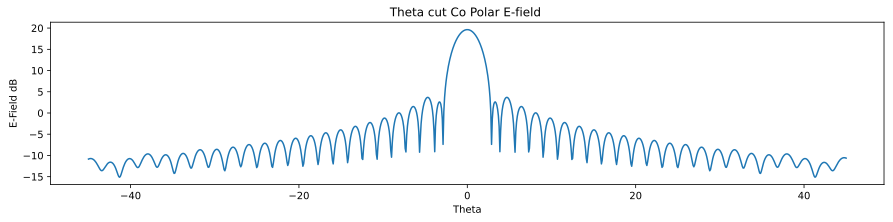

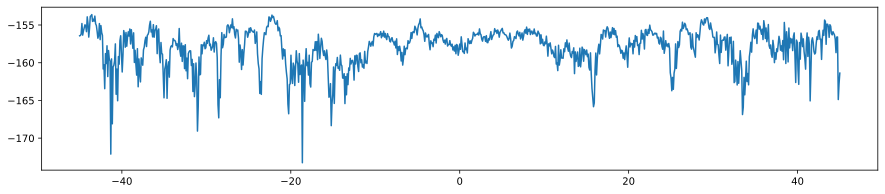

In [21]:
file_to_open = cut_folder / "30.cut"
V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP = np.genfromtxt(file_to_open, max_rows=1, skip_header=1)
print(V_INI, V_INC, V_NUM, C, ICOMP, ICUT, NCOMP)
data = np.genfromtxt(file_to_open, skip_header=2,dtype = np.float32).T
print(data.shape)


thetas = np.linspace(-45.0, 45.0, int(V_NUM))
copolar = np.sqrt(data[0]**2 + data[1]**2)
xpolar = np.sqrt(data[2]**2 + data[3]**2)
copolar_dB = 10*np.log10(copolar)
xpolar_dB = 10*np.log10(xpolar)
plt.figure(figsize=(15,3))
plt.plot(thetas, copolar_dB)
plt.title('Theta cut Co Polar E-field ')
plt.xlabel('Theta')
plt.ylabel('E-Field dB')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(thetas, xpolar_dB)
plt.show()


# Experimentation with feed forward models overfitting

Here we are exprimenting with overfitting a single cut of the E field of an antenna, and looking at what we can learn from this. 


## 1. mapping of antenna parameters directly to subspace of electric field

$$\chi \rightarrow \boldsymbol{E}$$

In [4]:
## Common hyperparameters
LEARNING_RATE = 1e-5;
EPOCHS = int(1e5);

print(np.mean(copolar_dB))

-3.0966783


In [5]:

criterion = torch.nn.MSELoss() # Mean squared error


NN = 100;
class FullSpaceNet(nn.Module):
    def __init__(self):
        super(FullSpaceNet, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(3, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, int(V_NUM)))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(np.mean(copolar_dB))
        
        
        
## Make forward pass
fullSpaceNet = FullSpaceNet()
fullSpaceNet.apply(init_weights)
t_data = torch.Tensor([+4.1666666667E-02,5.7777777778E-01,0.0000000000E+00])
print(fullSpaceNet(t_data))

loss = criterion(input = fullSpaceNet(t_data), target = torch.from_numpy(copolar_dB))
print(loss)



tensor([-3.4894, -2.9110, -3.8135,  ..., -3.2768, -2.5609, -3.0438],
       grad_fn=<AddBackward0>)
tensor(54.5323, grad_fn=<MseLossBackward>)


In [6]:




startTime = datetime.now()
optimizer = torch.optim.AdamW(fullSpaceNet.parameters(),lr = LEARNING_RATE)
loss_array = []
for epoch in range(EPOCHS):
    
    out = fullSpaceNet(t_data)
    
    loss = criterion(input = out, target = torch.from_numpy(copolar))
    #Gradients
    loss.backward()
    loss_array.append(loss.detach().numpy())
    #Step Optimizer
    optimizer.step()
    if epoch%(EPOCHS/10) == 0:
        print(loss)

print('Training time:', datetime.now()-startTime)


tensor(90.6416, grad_fn=<MseLossBackward>)
tensor(22.6433, grad_fn=<MseLossBackward>)
tensor(5.6322, grad_fn=<MseLossBackward>)
tensor(9.1159, grad_fn=<MseLossBackward>)
tensor(22.1336, grad_fn=<MseLossBackward>)
tensor(33.9799, grad_fn=<MseLossBackward>)
tensor(19.7188, grad_fn=<MseLossBackward>)
tensor(7.2423, grad_fn=<MseLossBackward>)
tensor(7.7069, grad_fn=<MseLossBackward>)
tensor(15.4829, grad_fn=<MseLossBackward>)
Training time: 0:02:12.409609


In [7]:
print('Training time', datetime.now()-startTime)

Training time 0:02:12.416589


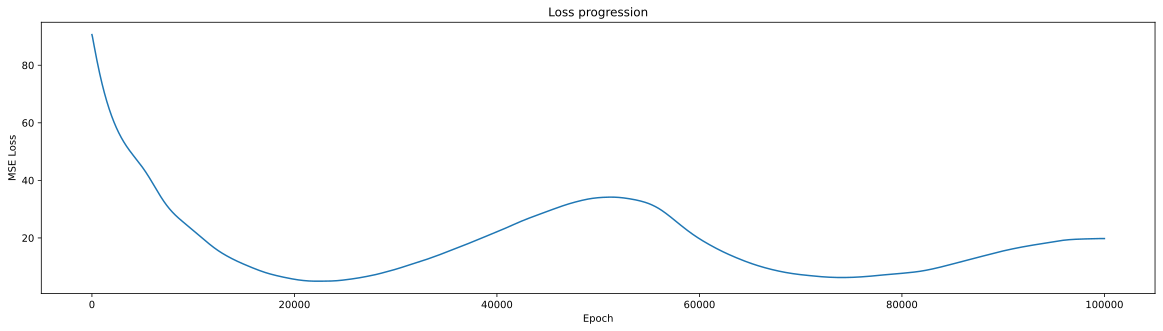

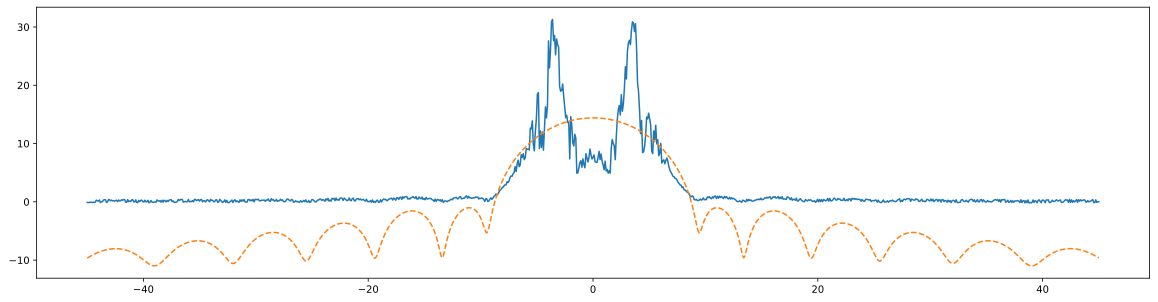

In [8]:
plt.figure(figsize = (20,5))
plt.plot(loss_array)
plt.title('Loss progression')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')



plt.figure(figsize = (20,5))
plt.plot(thetas,fullSpaceNet(t_data).detach().numpy())
plt.plot(thetas,copolar_dB,label = 'Target',linestyle = '--')

#plt.plot(thetas,net(t_data).detach().numpy()-copolar_dB)

## Mapping single output with theta being a parameter

In [9]:
NN = 100;
class SingleThetaNet(nn.Module):
    def __init__(self):
        super(SingleThetaNet, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(4, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, 1))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
## Make forward pass
singleThetaNet = SingleThetaNet()
singleThetaNet.apply(init_weights)

parameters = torch.Tensor([[+4.1666666667E-02,5.7777777778E-01,0.0000000000E+00, theta] for theta in thetas])

## Test forward pass
print(singleThetaNet(parameters))

tensor([[-4.4577],
        [-4.4576],
        [-4.4576],
        ...,
        [-4.3771],
        [-4.3772],
        [-4.3773]], grad_fn=<AddmmBackward>)


In [16]:


startTime = datetime.now()
criterion = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.AdamW(singleThetaNet.parameters(),lr = LEARNING_RATE)
copolar_dB_torch = torch.reshape(torch.from_numpy(copolar_dB), (1001,1))
loss_array = []
for epoch in range(EPOCHS):
    
    out = singleThetaNet(parameters)
    
    loss = criterion(input = out, target = copolar_dB_torch)
    #Gradients
    loss.backward()
    loss_array.append(loss.detach().numpy())
    #Step Optimizer
    optimizer.step()
    if epoch%(EPOCHS/10) == 0:
        print(loss)

print('Training time:', datetime.now()-startTime)

tensor(2.6451, grad_fn=<MseLossBackward>)
tensor(4589.9824, grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

Text(0, 0.5, 'MSE Loss')

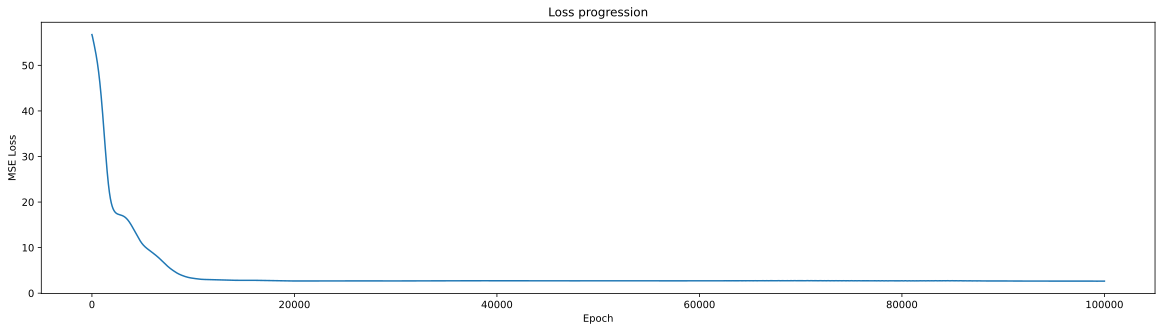

In [15]:
       
plt.figure(figsize = (20,5))
plt.plot(loss_array)
plt.title('Loss progression')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

[-8.760678 -8.751471 -8.74205  ... -8.903427 -8.906047 -8.908664]


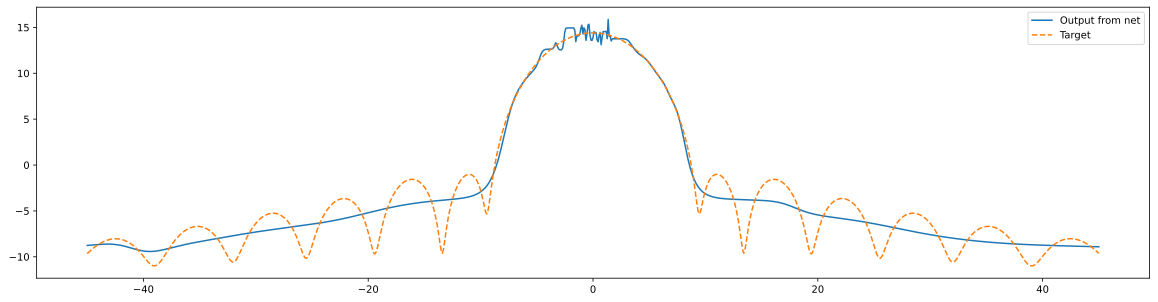

In [12]:
        
netOutput = singleThetaNet(parameters).detach().numpy().flatten()
print(netOutput)

plt.figure(figsize = (20,5))
plt.plot(thetas,netOutput,label = 'Output from net')
plt.plot(thetas,copolar_dB,label = 'Target',linestyle = '--')
#plt.plot(thetas,netOutput-copolar_dB,label = 'Net error')
plt.legend()

# Easier to estimate coefficients of FFT?

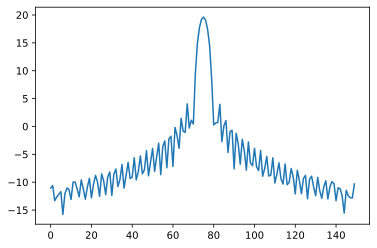

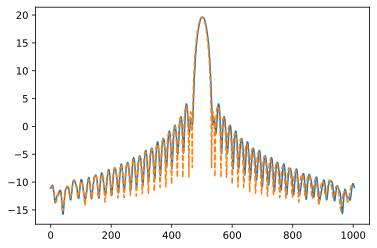

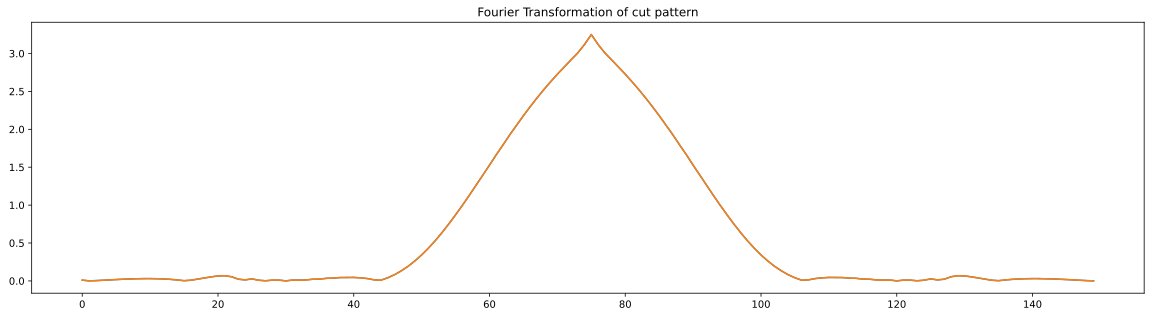

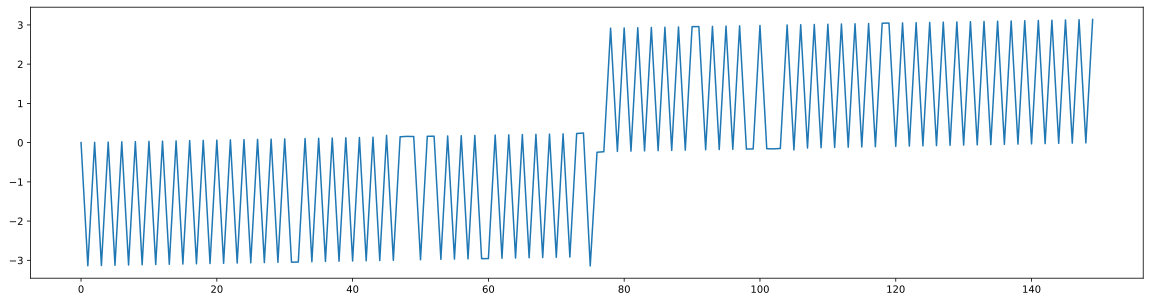

In [102]:



from scipy.fft import fft, ifft
from scipy import signal


copolar_downsample=signal.resample(copolar,150)

y = fft(copolar_downsample)
x_ifft = ifft(y)

plt.figure()
plt.plot(10*np.log10(copolar_downsample))


plt.figure()
plt.plot(10*np.log10(signal.resample(copolar_downsample,1005)))
plt.plot(10*np.log10(copolar),linestyle = '--')



plt.figure(figsize = (20,5))
plt.plot(abs(np.roll(y,len(y)//2))/len(copolar_downsample))
plt.plot(abs(np.roll(y,len(y)//2))/len(copolar_downsample))
plt.title('Fourier Transformation of cut pattern')

plt.figure(figsize = (20,5))
plt.plot(np.angle(y))

NN = 100;
class FFTNet(nn.Module):
    def __init__(self):
        super(FFTNet, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(3, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, NN),
                                       nn.Tanh(),
                                       nn.Linear(NN, int(V_NUM)))
        
    def forward(self, x):
        output = self.regressor(x)
        return output

    
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(np.mean(copolar_dB))






# What is the limit where i preserve x% of information by fourier downsampling?